# Курсовой проект Библиотеки Python для Data Science: продолжение<a class="anchor" id="task"></a>

### Постановка задачи<a class="anchor" id="task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

# Вариант решения: масштабирование<a class="anchor" id="task"></a>

**План работы, заметки**

К базовому варианту добавляем масштабирование

1. Минимально познакомиться с данными
2. Заполнить пропуски простым методом (медиана, мода)
3. Отмасшабировать данные
4. Обучить модели
5. Посчитать метрику качества

**Подключение библиотек**

In [58]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost
#!pip install missingno
#!conda install xgboost
#!conda install lightgbm
#!conda install catboost

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import missingno
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV, \
                                     RandomizedSearchCV, ShuffleSplit, cross_val_score, \
                                     learning_curve)
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score, precision_score)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

**Скрипты**

In [60]:
#Уменьшение памяти, занимаемой датасетом
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
           # df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [61]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [62]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [63]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [64]:
DATA_PATH = Path('C:/Users/Данила/Documents/Data science/Python библиотеки 2/course_project')

# input
TRAIN_DATASET_PATH = DATA_PATH / 'train.csv'
TEST_DATASET_PATH = DATA_PATH / 'test.csv'

# output
PREP_TRAIN_B_PATH = DATA_PATH / 'train_prep_basic.csv'
PREP_TEST_B_PATH = DATA_PATH / 'test_prep_basic.csv'
SCALER_FILE_PATH = DATA_PATH / 'scaler.pkl'

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Загрузка данных**

In [65]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.rename(columns = {'Home Ownership':'Home_Ownership', 'Annual Income':'Annual_Income',
                           'Years in current job':'Years_in_current_job', 'Tax Liens':'Tax_Liens',
                           'Number of Open Accounts':'Number_of_Open_Accounts',
                           'Years of Credit History':'Years_of_Credit_History',
                           'Maximum Open Credit':'Maximum_Open_Credit',
                           'Number of Credit Problems':'Number_of_Credit_Problems',
                           'Months since last delinquent':'Months_since_last_delinquent',
                           'Current Loan Amount':'Current_Loan_Amount',
                           'Current Credit Balance':'Current_Credit_Balance', 'Monthly Debt':'Monthly_Debt',
                           'Credit Score':'Credit_Score', 'Credit Default':'Credit_Default'}, inplace = True)
train_df.head()

,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Purpose,Term,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [66]:
train_df.shape

(7500, 17)

In [67]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home_Ownership                7500 non-null   object 
 1   Annual_Income                 5943 non-null   float64
 2   Years_in_current_job          7129 non-null   object 
 3   Tax_Liens                     7500 non-null   float64
 4   Number_of_Open_Accounts       7500 non-null   float64
 5   Years_of_Credit_History       7500 non-null   float64
 6   Maximum_Open_Credit           7500 non-null   float64
 7   Number_of_Credit_Problems     7500 non-null   float64
 8   Months_since_last_delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current_Loan_Amount           7500 non-null   float64
 13  Cur

In [68]:
train_df.Home_Ownership.unique

<bound method Series.unique of 0            Own Home
1            Own Home
2       Home Mortgage
3            Own Home
4                Rent
            ...      
7495             Rent
7496    Home Mortgage
7497             Rent
7498    Home Mortgage
7499             Rent
Name: Home_Ownership, Length: 7500, dtype: object>

**Приведение типов**

In [69]:
for colname in ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']:
    train_df[colname] = train_df[colname].astype(str)

**Уменьшение объема памяти датасета**

In [70]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 2.68 MB
Memory usage after optimization is: 2.28 MB
Decreased by 14.7%


**Обзор целевой переменной**

In [72]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit_Default, dtype: int64

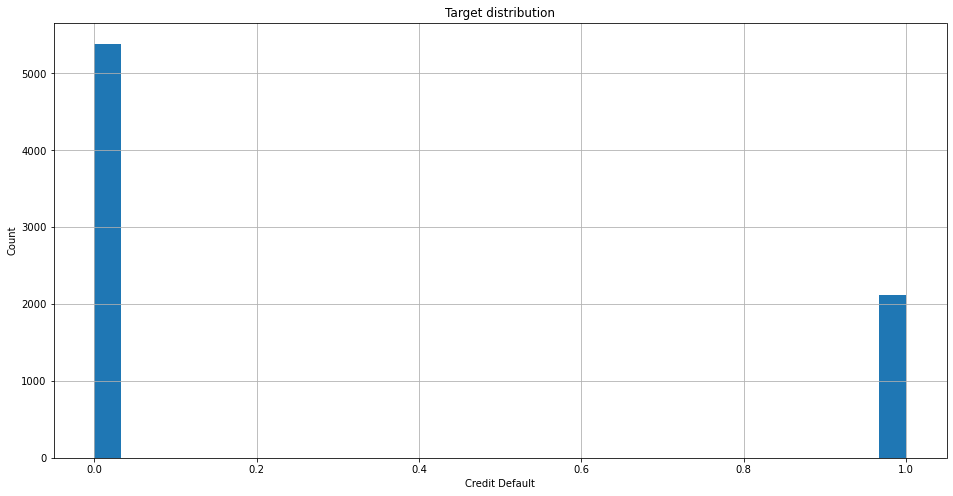

In [73]:
plt.figure(figsize = (16, 8))

train_df[TARGET_NAME].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Credit Default')

plt.title('Target distribution')
plt.show()

**Обзор количественных признаков**

In [74]:
train_df.describe()

,Annual_Income,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


array([[<AxesSubplot:title={'center':'Annual_Income'}>,
        <AxesSubplot:title={'center':'Tax_Liens'}>,
        <AxesSubplot:title={'center':'Number_of_Open_Accounts'}>],
       [<AxesSubplot:title={'center':'Years_of_Credit_History'}>,
        <AxesSubplot:title={'center':'Maximum_Open_Credit'}>,
        <AxesSubplot:title={'center':'Number_of_Credit_Problems'}>],
       [<AxesSubplot:title={'center':'Months_since_last_delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current_Loan_Amount'}>],
       [<AxesSubplot:title={'center':'Current_Credit_Balance'}>,
        <AxesSubplot:title={'center':'Monthly_Debt'}>, <AxesSubplot:>]],
      dtype=object)

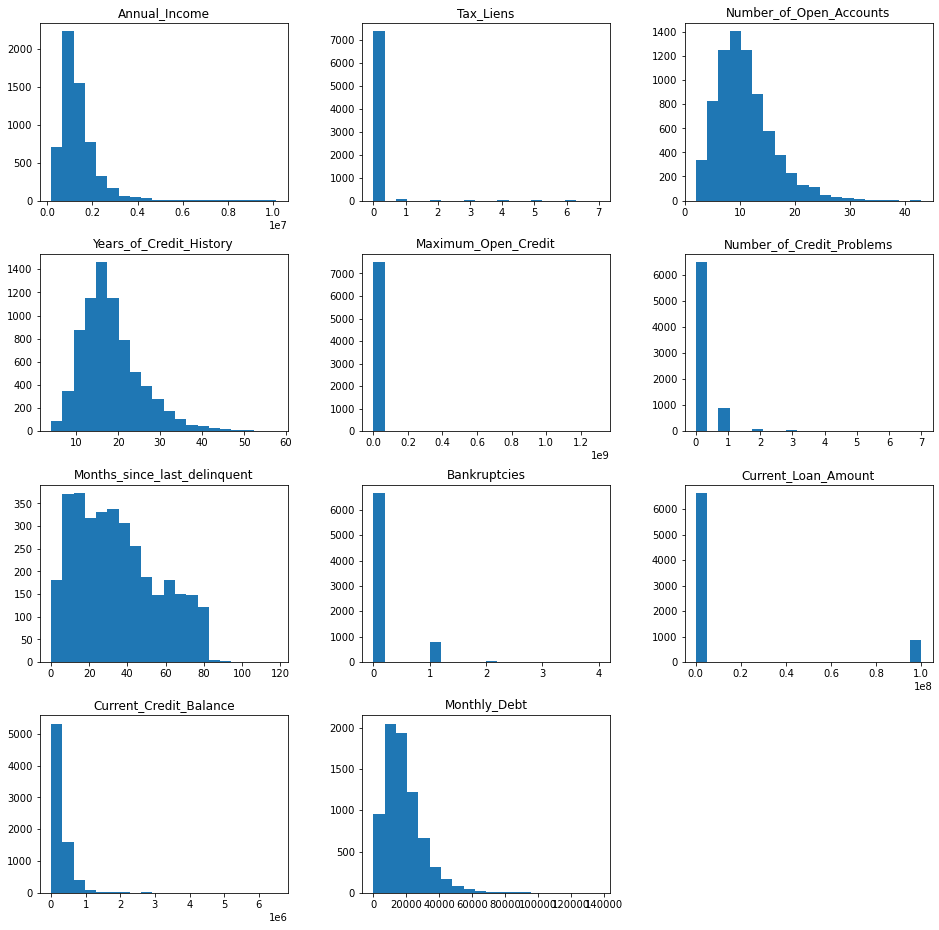

In [75]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False)

**Обзор номинативных признаков**

In [76]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home_Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64
****************************************************************************************************

Years_in_current_job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

**Обработка пропусков**


Preview of data with null values:
xxxxxxxxxxxxx
  Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0       Own Home       482087.0                  nan        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                     11.0                26.299999             685960.0   
1                     15.0                15.300000            1181730.0   
2                     11.0                35.000000            1182434.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   

              Purpose        Term  Current_Loan_Amount  \
0  debt consol

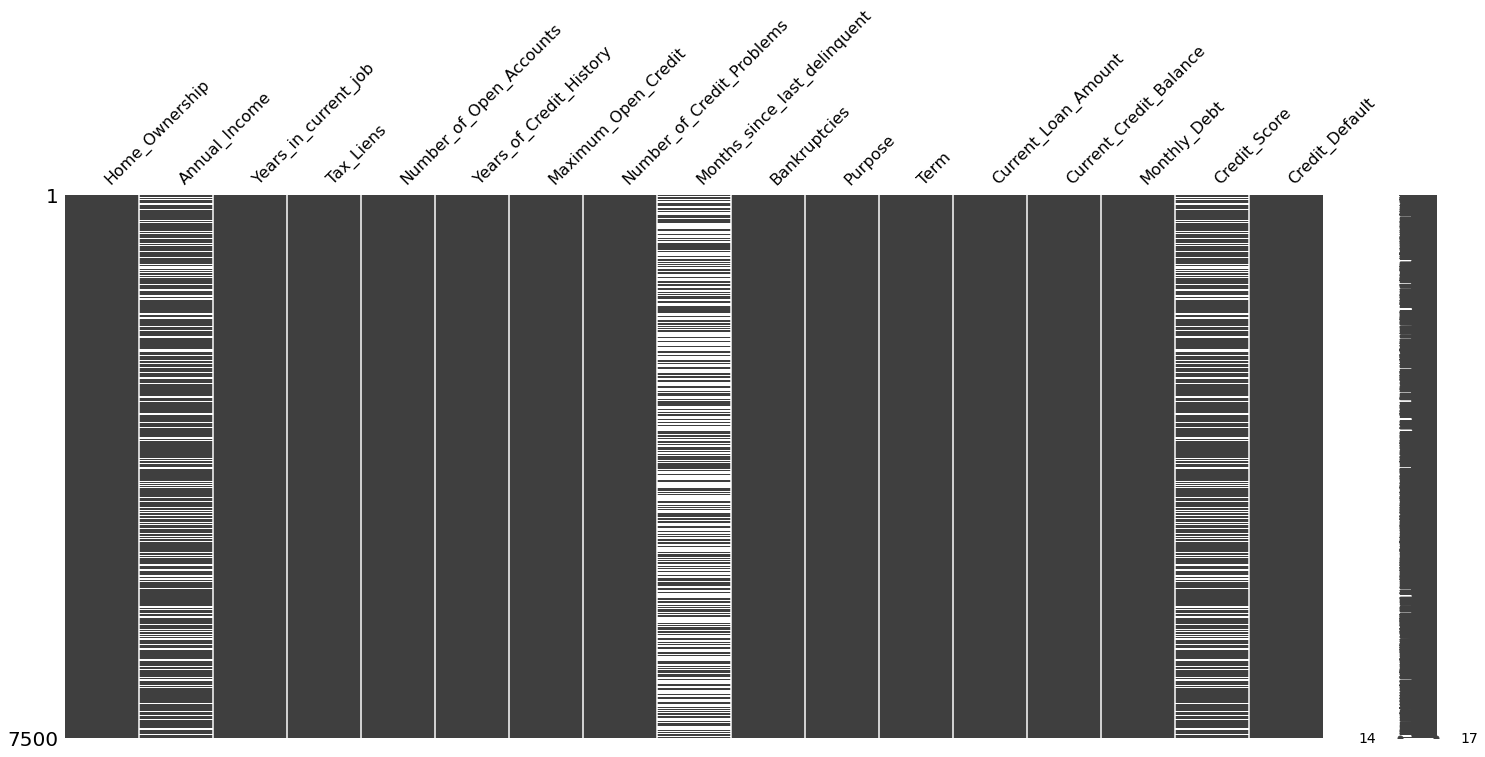

In [77]:
if len(train_df[train_df.isnull().any(axis=1)] != 0):
    print("\nPreview of data with null values:\nxxxxxxxxxxxxx")
    print(train_df[train_df.isnull().any(axis=1)].head(3))
    missingno.matrix(train_df)
    plt.show()

In [78]:
train_df.isna().sum()

Home_Ownership                     0
Annual_Income                   1557
Years_in_current_job               0
Tax_Liens                          0
Number_of_Open_Accounts            0
Years_of_Credit_History            0
Maximum_Open_Credit                0
Number_of_Credit_Problems          0
Months_since_last_delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current_Loan_Amount                0
Current_Credit_Balance             0
Monthly_Debt                       0
Credit_Score                    1557
Credit_Default                     0
dtype: int64

In [79]:
median = train_df['Annual_Income'].median()
train_df['Annual_Income'].fillna(median, inplace=True)

In [80]:
median = train_df['Months_since_last_delinquent'].median()
train_df['Months_since_last_delinquent'].fillna(median, inplace=True)

In [81]:
median = train_df['Bankruptcies'].median()
train_df['Bankruptcies'].fillna(median, inplace=True)

In [82]:
median = train_df['Credit_Score'].median()
train_df['Credit_Score'].fillna(median, inplace=True)

In [83]:
mode = train_df['Years_in_current_job'].mode()
train_df['Years_in_current_job'].fillna(mode, inplace=True)

<AxesSubplot:>

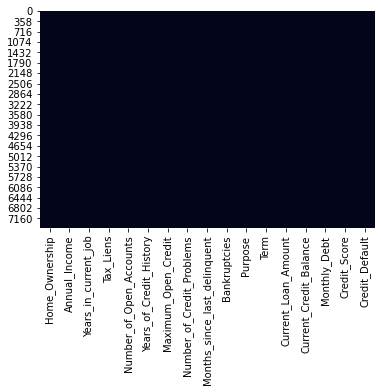

In [84]:
sns.heatmap(train_df.isnull(), cbar=False)

**Построение новых признаков**

In [85]:
for cat_colname in train_df.select_dtypes(include='object').columns[1:]:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[cat_colname], prefix=cat_colname)], axis=1)
train_df.head()

,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,nan,0.0,11.0,26.299999,685960.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home_Ownership                  7500 non-null   object 
 1   Annual_Income                   7500 non-null   float32
 2   Years_in_current_job            7500 non-null   object 
 3   Tax_Liens                       7500 non-null   float32
 4   Number_of_Open_Accounts         7500 non-null   float32
 5   Years_of_Credit_History         7500 non-null   float32
 6   Maximum_Open_Credit             7500 non-null   float32
 7   Number_of_Credit_Problems       7500 non-null   float32
 8   Months_since_last_delinquent    7500 non-null   float32
 9   Bankruptcies                    7500 non-null   float32
 10  Purpose                         7500 non-null   object 
 11  Term                            7500 non-null   object 
 12  Current_Loan_Amount             75

In [87]:
train_df.rename(columns = {'Years_in_current_job_< 1 year':'Years_in_current_job_less_1_year',
                             'Years_in_current_job_1 year':'Years_in_current_job_1_year',
                             'Years_in_current_job_10+ years':'Years_in_current_job_10+_years',
                             'Years_in_current_job_2 years':'Years_in_current_job_2_years',
                             'Years_in_current_job_3 years':'Years_in_current_job_3_years',
                             'Years_in_current_job_4 years':'Years_in_current_job_4_years',
                             'Years_in_current_job_5 years':'Years_in_current_job_5_years',
                             'Years_in_current_job_6 years':'Years_in_current_job_6_years',
                             'Years_in_current_job_7 years':'Years_in_current_job_7_years',
                             'Years_in_current_job_8 years':'Years_in_current_job_8_years',
                             'Years_in_current_job_9 years':'Years_in_current_job_9_years',
                             'Purpose_business loan':'Purpose_business_loan',
                             'Purpose_buy a car':'Purpose_buy_a_car',
                             'Purpose_buy house':'Purpose_buy_house',
                             'Purpose_debt consolidation':'Purpose_debt_consolidation',
                             'Purpose_educational expenses':'Purpose_educational_expenses',
                             'Purpose_home improvements':'Purpose_home_improvements',
                             'Purpose_major purchase':'Purpose_major_purchase',
                             'Purpose_medical bills':'Purpose_medical_bills',
                             'Purpose_renewable energy':'Purpose_renewable_energy',
                             'Purpose_small business':'Purpose_small_business',
                             'Purpose_take a trip':'Purpose_take_a_trip',
                             'Term_Long Term':'Long_Term',
                             'Term_Short Term':'Short_Term',
                            }, inplace = True)

**Выделение целевой переменной и групп признаков**

In [71]:
TARGET_NAME = 'Credit_Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = ['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History',
                     'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Months_since_last_delinquent', 'Bankruptcies',
                     'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt']

CAT_FEATURE_NAMES = ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

**Масштабирование данных**

In [89]:
scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

train_df = df_norm.copy()

**Сохранение модели для масштабирования**

In [90]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Разбиение на train и valid**

In [91]:
X = train_df[NUM_FEATURE_NAMES + NEW_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

### Обучение модели<a class="anchor" id="train_test_saving"></a> 

**Логистическая регрессия**

In [92]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.95      0.84      3771
           1       0.58      0.17      0.26      1479

    accuracy                           0.73      5250
   macro avg       0.66      0.56      0.55      5250
weighted avg       0.70      0.73      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1616
           1       0.46      0.13      0.20       634

    accuracy                           0.71      2250
   macro avg       0.60      0.53      0.51      2250
weighted avg       0.66      0.71      0.65      2250

CONFUSION MATRIX

col_0              0   1
Credit_Default          
0               1519  97
1                552  82


**k ближайших соседей**

In [93]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3771
           1       0.68      0.44      0.54      1479

    accuracy                           0.79      5250
   macro avg       0.75      0.68      0.70      5250
weighted avg       0.77      0.79      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1616
           1       0.38      0.21      0.27       634

    accuracy                           0.68      2250
   macro avg       0.56      0.54      0.53      2250
weighted avg       0.64      0.68      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1402  214
1                502  132


**Дерево решений**

In [94]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.5},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      3771
           1       0.43      0.60      0.51      1479

    accuracy                           0.67      5250
   macro avg       0.63      0.65      0.63      5250
weighted avg       0.71      0.67      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1616
           1       0.39      0.57      0.46       634

    accuracy                           0.63      2250
   macro avg       0.59      0.61      0.59      2250
weighted avg       0.68      0.63      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1051  565
1                274  360


**XGBoost**

In [95]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21, 
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_val, y_train, y_val)

[13:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3771
           1       0.98      0.83      0.90      1479

    accuracy                           0.95      5250
   macro avg       0.96      0.91      0.93      5250
weighted avg       0.95      0.95      0.95      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1616
           1       0.45      0.26      0.32       634

    accuracy                           0.70      2250
   macro avg       0.60      0.57      0.57      2250
weighted avg       0.66      0.70      0.67      2250

CONFUSION MATRIX

col_0

**LightGBM**

In [96]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:3.6},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3771
           1       0.61      0.99      0.76      1479

    accuracy                           0.82      5250
   macro avg       0.80      0.87      0.81      5250
weighted avg       0.89      0.82      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.59      0.69      1616
           1       0.38      0.64      0.48       634

    accuracy                           0.61      2250
   macro avg       0.60      0.62      0.58      2250
weighted avg       0.69      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               961  655
1               227  407
Wall time: 141 ms


**CatBoost**

In [97]:
X = train_df[BASE_FEATURE_NAMES]
y = train_df[TARGET_NAME]
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [98]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [99]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3771
           1       0.74      0.85      0.79      1479

    accuracy                           0.87      5250
   macro avg       0.84      0.87      0.85      5250
weighted avg       0.88      0.87      0.88      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1616
           1       0.49      0.56      0.52       634

    accuracy                           0.71      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1251  365
1                281  353


In [100]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=50,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                     )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2.9 s


In [101]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.7133198106828939,
  'Logloss': 0.49371005377197485,
  'F1': 0.7495000306451951,
  'Precision:use_weights=false': 0.595372460496614,
  'Precision:use_weights=true': 0.7895465385471145,
  'Recall:use_weights=true': 0.7133198106828939},
 'validation': {'Recall:use_weights=false': 0.5725552050473186,
  'Logloss': 0.5518129094453927,
  'F1': 0.6360994606642388,
  'Precision:use_weights=false': 0.52,
  'Precision:use_weights=true': 0.7341959825088411,
  'Recall:use_weights=true': 0.5725552050473186}}

In [102]:
evaluate_preds(model_catb, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3771
           1       0.57      0.66      0.61      1479

    accuracy                           0.76      5250
   macro avg       0.71      0.73      0.72      5250
weighted avg       0.77      0.76      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1616
           1       0.50      0.57      0.53       634

    accuracy                           0.72      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit_Default           
0               1248  368
1                271  363


**Выбор лучшей модели и подбор гиперпараметров**

In [103]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':50
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [104]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [105]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [106]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.598388377
bestIteration = 48

0:	loss: 0.5983884	best: 0.5983884 (0)	total: 491ms	remaining: 6.87s

bestTest = 0.6255350726
bestIteration = 181

1:	loss: 0.6255351	best: 0.6255351 (1)	total: 2.33s	remaining: 15.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6742504886
bestIteration = 447

2:	loss: 0.6742505	best: 0.6742505 (2)	total: 6.77s	remaining: 27.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6742504886
bestIteration = 447

3:	loss: 0.6742505	best: 0.6742505 (2)	total: 11.8s	remaining: 32.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6742504886
bestIteration = 447

4:	loss: 0.6742505	best: 0.6742505 (2)	total: 16.6s	remaining: 33.3s

bestTest = 0.6031876604
bestIteration = 49

5:	loss: 0.6031877	best: 0.6742505 (2)	total: 17.4s	remaining: 26.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6275831117
bestIteration = 123

6:	loss: 0.6275831	best: 0.6742505 (2)	total: 20.4s

In [107]:
grid_search

{'params': {'depth': 3, 'iterations': 500},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [108]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
360,360,0.669318,0.026895,0.730542,0.006308,0.543644,0.006789,0.507434,0.003870
399,399,0.669046,0.019881,0.740349,0.007929,0.543379,0.006675,0.501377,0.003623
356,356,0.668935,0.026987,0.730554,0.007171,0.543584,0.006861,0.508064,0.003879
398,398,0.668910,0.021181,0.740576,0.007403,0.543360,0.006651,0.501505,0.003685
358,358,0.668862,0.025984,0.730358,0.007315,0.543668,0.006744,0.507778,0.003873


In [109]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=500, max_depth=3)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val))

evaluate_preds(final_model, X_train, X_val, y_train, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.33      0.48      3771
           1       0.35      0.90      0.50      1479

    accuracy                           0.49      5250
   macro avg       0.62      0.62      0.49      5250
weighted avg       0.74      0.49      0.49      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.32      0.47      1616
           1       0.34      0.89      0.49       634

    accuracy                           0.48      2250
   macro avg       0.61      0.61      0.48      2250
weighted avg       0.73      0.48      0.48      2250

CONFUSION MATRIX

col_0             0     1
Credit_Default           
0               521  1095
1                69   565
Wall time: 689 ms


**Вывод**

Лучшая модель Catboost (silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=50,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                     )
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3771
           1       0.57      0.66      0.61      1479

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1616
           1       0.50      0.57      0.53       634
